In [1]:
#| default_exp topology

In [2]:
#| export

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import igl

In [3]:
#| export

import jax
import jax.numpy as jnp

In [4]:
#| export

from jaxtyping import Float, Int, Bool, PyTree 
from typing import Any, Iterable, NamedTuple
from pathlib import Path
from enum import IntEnum

import dataclasses

import functools

In [5]:
#| export

from triangulax import trigonometry as trig
from triangulax.triangular import TriMesh
from triangulax.mesh import HeMesh, GeomMesh
import triangulax.mesh as msh

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [8]:
#| hide

%load_ext jaxtyping 
%jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving). For those, disable type checks

## Topological modifications in half-edge meshes

We often need to not only move the vertices of a mesh, but modify the connectivity. In half-edge meshes, there are several "elementary" mesh modifications.
For `triangulax`, by far the most important one is the edge flip (see below). It is the only modification that preserves the number of all mesh elements, and is thus relatively easy to make compatible with JAX and differentiable programming.

### Edge flips / T1s

In our simulations, cells will exchange neighbors (T1-event). In the triangulation, this corresponds to an edge flip. We now implement the edge flip algorithm for `HeMesh`es. We basically edit the various connectivity arrays (in a JAX-compatible way).

The algorithm (and the naming conventions in `flip_edge`) are from [here](https://jerryyin.info/geometry-processing-algorithms/half-edge/).

**Before**

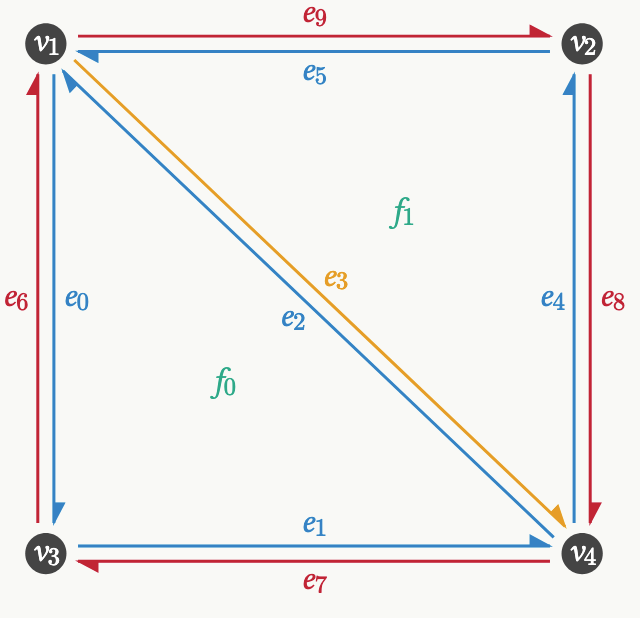

**After**

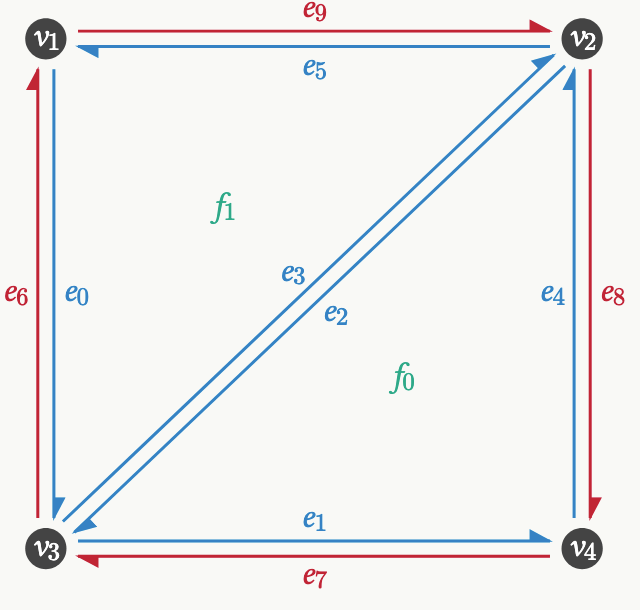

In [9]:
#| export

@functools.partial(jax.jit, static_argnames=['check_boundary'])
def flip_edge(hemesh: HeMesh, e: Int[jax.Array, ""], check_boundary: bool = False) -> HeMesh:
    """
    Flip half-edge e in a half-edge mesh.
    
    See https://jerryyin.info/geometry-processing-algorithms/half-edge/. The algorithm
    is slightly modified since we keep track of the origin and destination of a half-edge,
    and use arrays instead of pointers. Returns a new HeMesh, does not modify in-place.
    """
    if check_boundary:
        assert (hemesh.heface[e] !=-1 and hemesh.heface[hemesh.twin[e]] != -1), "Cannot flip boundary edge"

    # identify relevant elements
    e5 = hemesh.prv[e]
    e4 = hemesh.nxt[e]
    twin = hemesh.twin[e]
    e1 = hemesh.prv[twin] 
    e0 = hemesh.nxt[twin] 

    # make sure there’s no vertex or face references to e or twin
    incident = hemesh.incident.at[jnp.array([hemesh.orig[e], hemesh.orig[twin]])].set(
        jnp.array([hemesh.twin[e5], hemesh.twin[e1]]))
    face_incident = hemesh.face_incident.at[jnp.array([hemesh.heface[e], hemesh.heface[twin]])].set(
        jnp.array([e5, e1])) # e1, e5 don't change face

    # update the data structure to do the T1
    nxt = hemesh.nxt.at[jnp.array([e, twin])].set(jnp.array([e5, e1]))
    prv = hemesh.prv.at[jnp.array([e, twin])].set(jnp.array([e0, e4]))
    orig = hemesh.orig.at[jnp.array([e, twin])].set(jnp.array([hemesh.orig[e1], hemesh.orig[e5]]) )
    dest = hemesh.dest.at[jnp.array([e, twin])].set(jnp.array([hemesh.dest[e4], hemesh.dest[e0]]))

    nxt = nxt.at[jnp.array([e0, e1, e4, e5])].set(jnp.array([e, e4, twin, e0]) )
    prv = prv.at[jnp.array([e0, e1, e4, e5])].set(jnp.array([e5, twin, e1, e]) )
    heface = hemesh.heface.at[jnp.array([e0, e4])].set(jnp.array([hemesh.heface[e5], hemesh.heface[e1]]))

    return HeMesh(incident, orig, dest, jnp.copy(hemesh.twin), nxt, prv, heface, face_incident, hemesh.inf_vertices)

In [10]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

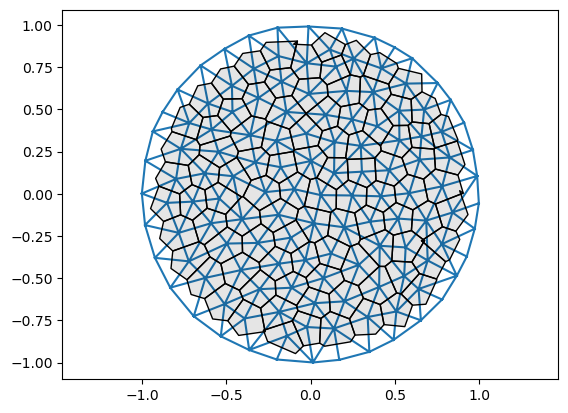

In [11]:
plt.triplot(*geommesh.vertices.T, hemesh.faces)
ax = plt.gca()
p = msh.cellplot(hemesh, geommesh.face_positions,
                 cell_colors=np.array([0,0,0,0.1]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
plt.gca().add_collection(p)

plt.axis("equal")

In [12]:
# flip edge and recompute face positions

flipped_hemesh = flip_edge(hemesh, e=335)
flipped_geommesh = msh.set_voronoi_face_positions(geommesh, flipped_hemesh)

In [13]:
# connectivity is still valid

igl.is_edge_manifold(hemesh.faces)[0], igl.is_edge_manifold(flipped_hemesh.faces)[0], flipped_hemesh.iterate_around_vertex(100)

(True, True, Array([298, 299, 630, 632], dtype=int64))

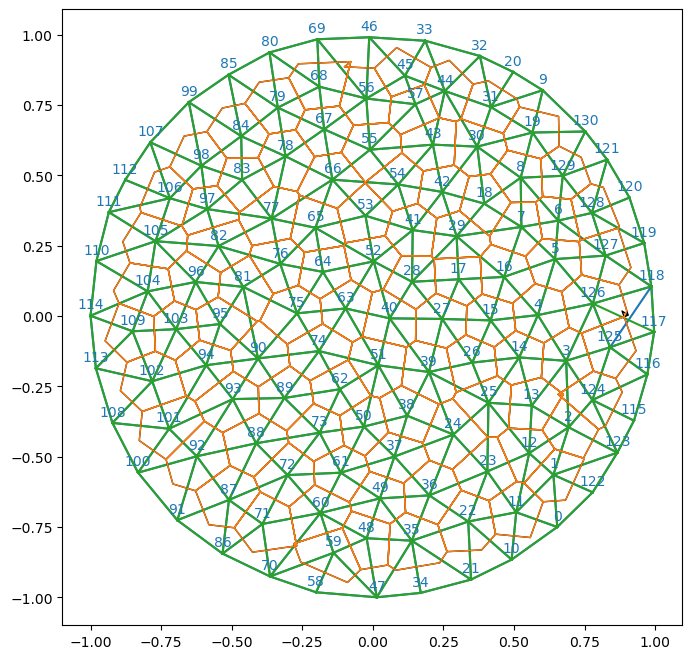

In [14]:
# you can see the flipped edge between vertices 126-117 in the plot below (middle right)

fig = plt.figure(figsize=(8,8))

plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*flipped_geommesh.vertices.T, flipped_hemesh.faces)

ax = plt.gca()
p1 = msh.cellplot(hemesh, geommesh.face_positions,
         cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
p2 = msh.cellplot(flipped_hemesh, flipped_geommesh.face_positions,
              cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "tab:orange"})
ax.add_collection(p1)
ax.add_collection(p2)
plt.axis("equal")

msh.label_plot(geommesh.vertices, hemesh.faces, fontsize=10, face_labels=False)

#### Repeated flips

In a simulation, we need to carry out edge flips at every timestep. The function `flip_edge(hemesh: HeMesh, e: int) -> HeMesh` does a single edge flip by modifying the connectivity arrays. Luckily, it is already JAX-compatible (we can JIT-compile it).

To carry out multiple flips, we must do the flips in sequence (otherwise, you risk leaving the mesh in an invalid state). To make things JAX-compatible, we do a `jax.lax.scan` scan over _all_ half-edges.

In [15]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [16]:
# let's detect all edges with negative dual length, and flip them.

dual_lengths = msh.get_signed_dual_he_length(geommesh.vertices, geommesh.face_positions, hemesh)
edges = jnp.where((dual_lengths < -0.05) & ~hemesh.is_bdry_edge & hemesh.is_unique)[0]
# we only want to flip unique hes!
edges, edges.size

(Array([  9, 185, 191, 335], dtype=int64), 4)

In [17]:
#| export

@jax.jit
def flip_by_id(hemesh: HeMesh, ids: Int[jax.Array, " flips"], to_flip: Bool[jax.Array, " flips"]) -> HeMesh:
    """Flip half-edges from ids array if the to_flip is True. Wraps flip_edge."""
    def scan_fun(h, x): # flips edge e if its length < 0 and edge is unique. Otherwise, you undo your flips!
        return jax.lax.cond(x[1], lambda hh: flip_edge(hh, x[0]), lambda hh: hh, h), None
    xs = jnp.stack([ids, to_flip], axis=1)  
    flipped_hemesh, _ = jax.lax.scan(scan_fun, init=hemesh, xs=xs)
    return flipped_hemesh

@jax.jit
def flip_all(hemesh: HeMesh, to_flip: Bool[jax.Array, " n_hes"]) -> HeMesh:
    """Flip all (unique) half-edges where to_flip is True in a half-edge mesh. Wraps flip_edge."""
    def scan_fun(h, e): # flips edge e if its length < 0 and edge is unique. Otherwise, you undo your flips!
        return jax.lax.cond(to_flip[e] & hemesh.is_unique[e],
                            lambda hh: flip_edge(hh, e), lambda hh: hh, h), None
    flipped_hemesh, _ = jax.lax.scan(scan_fun, init=hemesh, xs=jnp.arange(hemesh.n_hes) )
    return flipped_hemesh

In [18]:
to_flip = (dual_lengths < 0) & ~jnp.isnan(dual_lengths)

flipped_hemesh = flip_all(hemesh, to_flip=to_flip)

In [19]:
flipped_hemesh = flip_all(hemesh, to_flip=(dual_lengths<0.02)) # no extra recompile

In [20]:
flipped_geommesh = msh.set_voronoi_face_positions(geommesh, flipped_hemesh)

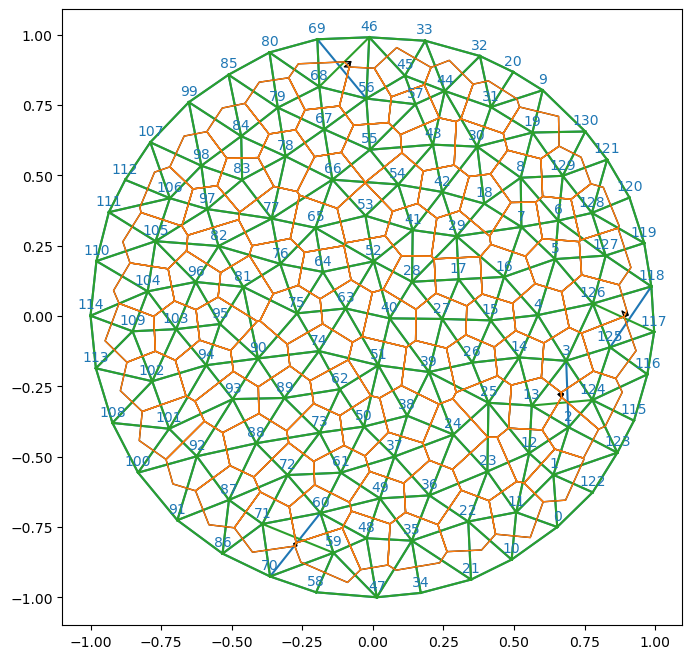

In [21]:
fig = plt.figure(figsize=(8,8))

plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*flipped_geommesh.vertices.T, flipped_hemesh.faces)

ax = plt.gca()
ax = plt.gca()
p1 = msh.cellplot(hemesh, geommesh.face_positions,
         cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
p2 = msh.cellplot(flipped_hemesh, flipped_geommesh.face_positions,
              cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "tab:orange"})
ax.add_collection(p1)
ax.add_collection(p2)
plt.axis("equal")

msh.label_plot(geommesh.vertices, hemesh.faces, fontsize=10, face_labels=False)

### Splitting and collapsing vertices 

The edge flip is the only topological modification of a half-edge mesh that leaves the number of vertices, edges, and faces constant. This makes it especially easy, and compatible with JAX's "static array size" paradigm.

However, we may also want to simulate processes (like cell division or death) where the number of cells _does_ change. Let's implement two elementary operation, which are inverses of another: edge collapse and vertex split. Let's start with edge collapse.

To split a half-edge `e` in a `hemesh`:

1. Delete faces `hemesh.heface[e]`, `hemesh.heface[hemesh.twin[e]]`
2. Delete all the half-edges in those faces.
3. Glue the "gap" back together.
3. Merge the vertices `hemesh.orig[e]`,  `hemesh.dest[e]`
We must be careful to preserve the manifold structure of the mesh, deal with edge cases. We can test the resulting half-edge mesh via plots, and use `libigl` to verify that the mesh is in a valid state.

Finally, we also need a datastructure to keep track of the map from the vertices/edges/faces of the inital mesh to that of the modified one.

**WARNING**: code not fully tested


In [22]:
%unload_ext jaxtyping

In [23]:
#| export

def remap_inds_removal_forward(N: int, removed: Int[jax.Array, " n_removed"]) -> Int[jax.Array, " N"]:
    """Remap indices after removal. Returns array arr[i] = i - (removed < i).sum()."""
    remap = jnp.arange(N)
    return remap - jnp.searchsorted(jnp.sort(removed), remap, side='left')  # left


def remap_inds_removal_reverse(N: int, removed: Int[jax.Array, " n_removed"]) -> Int[jax.Array, " N-n_removed"]:
    """Remap indices after removal. Reverse of remap_inds_removal_forward."""
    remap = jnp.arange(N)
    return jnp.delete(remap, removed, assume_unique_indices=True)


In [28]:
#| export

@jax.tree_util.register_dataclass
@dataclasses.dataclass(frozen=True)
class MeshReindexMap:
    """Old↔new index maps produced by topology-changing operations."""
    v_forward: Int[jax.Array, " n_vertices_old"]
    v_reverse: Int[jax.Array, " n_vertices_new"]
    f_forward: Int[jax.Array, " n_faces_old"]
    f_reverse: Int[jax.Array, " n_faces_new"]
    he_forward: Int[jax.Array, " n_hes_old"]
    he_reverse: Int[jax.Array, " n_hes_new"]
    info: dict[str, Any] = dataclasses.field(default_factory=dict, metadata=dict(static=True))


In [29]:
N = 10
removed = jnp.array([5, 2])
forward = remap_inds_removal_forward(N, removed)
reverse = remap_inds_removal_reverse(N, removed)

forward[6], reverse[2], jnp.allclose(forward[reverse], jnp.arange(N - removed.shape[0]))    

(Array(4, dtype=int64), Array(3, dtype=int64), Array(True, dtype=bool))

In [30]:
#| export

@functools.partial(jax.jit, static_argnames=['check_boundary']) 
def collapse_edge(hemesh: HeMesh, e: int, check_boundary=False
                  ) -> tuple[HeMesh, MeshReindexMap]:
    """
    Collapse half-edge e in a half-edge mesh. Keeps the origin vertex of e.
        
    Returns a new HeMesh (does not modify in-place), and three arrays for remapping
    vertex, half-edge, and face indices from the original mesh to the new mesh.

    JIT-compatible, but calling with different numbers of vertices/edges/faces will cause recompilation.
    """

    if check_boundary:
        assert not hemesh.is_bdry_edge[e] and not hemesh.is_inf_he[e], "Interior edges only"

    # identify relevant elements
    t = hemesh.twin[e]

    # make sure there’s no vertex references to e or twin
    incident = hemesh.incident.at[jnp.array([hemesh.orig[e], # v1 
                                             hemesh.orig[hemesh.prv[e]], # v2
                                             hemesh.orig[hemesh.prv[t]]])].set( # v4
                                  jnp.array([hemesh.twin[hemesh.prv[e]],
                                             hemesh.twin[hemesh.nxt[e]],
                                             hemesh.twin[hemesh.nxt[t]]]))
    # re-twin the half-edges
    twin = hemesh.twin
    twin = hemesh.twin.at[jnp.array([hemesh.twin[hemesh.prv[e]],
                                     hemesh.twin[hemesh.nxt[e]], 
                                     hemesh.twin[hemesh.prv[t]],
                                     hemesh.twin[hemesh.nxt[t]]])].set( 
                          jnp.array([hemesh.twin[hemesh.nxt[e]],
                                     hemesh.twin[hemesh.prv[e]],
                                     hemesh.twin[hemesh.nxt[t]],
                                     hemesh.twin[hemesh.prv[t]]]))
    # edit orign and dest for all hes in/out of v3
    orig = jnp.where(hemesh.orig==hemesh.dest[e], hemesh.orig[e], hemesh.orig)
    dest = jnp.where(hemesh.dest==hemesh.dest[e], hemesh.orig[e], hemesh.dest)

    # delete the elements
    v_delete = jnp.array([hemesh.dest[e]])
    hes_delete = jnp.array([e, hemesh.nxt[e], hemesh.prv[e],
                            t, hemesh.nxt[t], hemesh.prv[t]])
    fs_delete =  jnp.array([hemesh.heface[e], hemesh.heface[t]])
    incident = jnp.delete(incident, v_delete, assume_unique_indices=True)
    face_incident = jnp.delete(hemesh.face_incident, fs_delete, assume_unique_indices=True)
    
    def delete_he(arr): return jnp.delete(arr, hes_delete, assume_unique_indices=True)
    orig, dest = (delete_he(orig), delete_he(dest))
    twin = delete_he(twin)
    nxt, prv = (delete_he(hemesh.nxt), delete_he(hemesh.prv))
    heface = delete_he(hemesh.heface)

    # index remapping: identity for v < hemesh.dest[e], v-> v-1 for
    remap_v = remap_inds_removal_forward(hemesh.n_vertices, v_delete)
    remap_he = remap_inds_removal_forward(hemesh.n_hes, hes_delete)  
    remap_f = remap_inds_removal_forward(hemesh.n_faces, fs_delete)

    index_map = MeshReindexMap(v_forward=remap_v,
                               v_reverse=remap_inds_removal_reverse(hemesh.n_vertices, v_delete),
                               f_forward=remap_f,
                               f_reverse=remap_inds_removal_reverse(hemesh.n_faces, fs_delete),
                               he_forward=remap_he,
                               he_reverse=remap_inds_removal_reverse(hemesh.n_hes, hes_delete),
                               info={"operation": "collapse_edge", "collapsed_edge": e})
    
    inf_vertices = tuple(int(remap_v[v]) for v in hemesh.inf_vertices)

    # special case: boundary hes need "-1" face
    heface = remap_f[heface]
    is_bdry_he = jnp.delete(hemesh.heface == -1, hes_delete, assume_unique_indices=True)
    heface = jnp.where(is_bdry_he, -1, heface)

    new_hemesh = HeMesh(incident=remap_he[incident], orig=remap_v[orig], dest=remap_v[dest],
                        twin=remap_he[twin], nxt=remap_he[nxt], prv=remap_he[prv],
                        heface=heface, face_incident=remap_he[face_incident], inf_vertices=inf_vertices)

    return new_hemesh, index_map

In [31]:
# test on the existing example mesh. pick some interior, unique half-edge

candidates = np.where(np.asarray(hemesh.is_unique & (~hemesh.is_bdry_edge)))[0]
e_collapse = candidates[40]
print("Collapsing half-edge", e_collapse, "with vertices", int(hemesh.orig[e_collapse]), int(hemesh.dest[e_collapse]))

hemesh_collapsed, remap = collapse_edge(hemesh, e_collapse,)
vertices_collapsed =  geommesh.vertices[remap.v_reverse]


Collapsing half-edge 42 with vertices 8 129


In [32]:
hemesh, hemesh_collapsed # removes 1 vertex, 6 half-edges, and 2 faces

(HeMesh(N_V=131, N_HE=708, N_F=224), HeMesh(N_V=130, N_HE=702, N_F=222))

In [34]:
# stil valid mesh
(msh.test_mesh_validity(hemesh_collapsed), igl.is_edge_manifold(hemesh_collapsed.faces)[0],
 igl.is_vertex_manifold(hemesh_collapsed.faces)[0])

(True, True, np.True_)

In [36]:
%timeit _ = collapse_edge(hemesh, e_collapse,)

40.6 μs ± 2.64 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

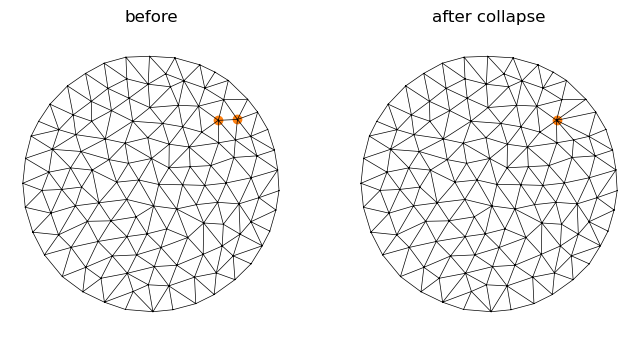

In [37]:
# visualize before/after
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
v1, v2 = (hemesh.orig[e_collapse], hemesh.dest[e_collapse])
plt.scatter(*geommesh.vertices[v1], c="tab:orange")
plt.scatter(*geommesh.vertices[v2], c="tab:orange")
plt.triplot(np.asarray(geommesh.vertices)[:, 0], np.asarray(geommesh.vertices)[:, 1], np.asarray(hemesh.faces), lw=0.5, color="k")
plt.title("before")
plt.axis("equal")
plt.axis("off")

plt.sca(ax[1])
plt.scatter(*geommesh.vertices[v1], c="tab:orange")
plt.triplot(np.asarray(vertices_collapsed)[:, 0], np.asarray(vertices_collapsed)[:, 1],
            np.asarray(hemesh_collapsed.faces), lw=0.5, color="k")
plt.title("after collapse")
plt.axis("equal")
plt.axis("off")

#### Split vertex ("cell division")

Next, let's create the opposite operation - splitting a vertex into two. To do so, we need to specify two half-edges, the "splitting axis", which meet at a common vertex. Like before, we also need a map of how hold and new mesh elements are related. We append the newly created mesh elements at the end of the different arrays.

In [38]:
#| export

def split_vertex(hemesh: HeMesh, e1: int, e2: int, check_args: bool=False) -> tuple[HeMesh, MeshReindexMap]:
    """
    Split a vertex into two along a "splitting axis" given by two half-edges whose originating at that vertex.
    
    New vertex inserted at origin of e2. The new vertex will be the final one in the array.

    This function is not JIT-compatible, since it depends on iterating around the vertex to update origins/destinations.
    """
    if check_args:
        assert hemesh.orig[e1]==hemesh.orig[e2] and not hemesh.heface[e1]==-1 and not hemesh.heface[e2]==-1, "invalid half edges"

    # create 1 new vertex, 6 new half-edges, and 2 new faces. By convention, at the end of the arrays
    incident = jnp.pad(hemesh.incident, (0, 1))
    face_incident = jnp.pad(hemesh.face_incident, (0, 2))
    orig, dest, twin, nxt, prv, heface = [jnp.pad(arr, (0, 6))
                                         for arr in [hemesh.orig, hemesh.dest, hemesh.twin, hemesh.nxt, hemesh.prv, hemesh.heface]]
    face_incident = jnp.pad(hemesh.face_incident, (0, 2))

    # the new elements are appended at the end
    vnew = hemesh.n_vertices
    fnew_1, fnew_2 = hemesh.n_faces, hemesh.n_faces+1 # faces of triangle of twin[e1] and triangle of twin[e2]
    enew_1, enew_2, enew_3 = hemesh.n_hes, hemesh.n_hes+1, hemesh.n_hes+2 # fnew_1, enew_1 is twin[e1]
    enew_4, enew_5, enew_6 = hemesh.n_hes+3, hemesh.n_hes+4, hemesh.n_hes+5 # fnew_2, enew_4 is twin[e2]

    # set incidents for new mesh elements
    incident = incident.at[vnew].set(e2)
    heface = heface.at[jnp.array([enew_1, enew_2, enew_3])].set(fnew_1)
    heface = heface.at[jnp.array([enew_4, enew_5, enew_6])].set(fnew_2)
    face_incident = face_incident.at[jnp.array([fnew_1, fnew_2])].set(jnp.array([enew_1, enew_4]))

    # origin and destination of new half-edges
    orig = orig.at[jnp.array([enew_1, enew_2, enew_3])].set(jnp.array([hemesh.dest[e1], hemesh.orig[e1], vnew]))
    orig = orig.at[jnp.array([enew_4, enew_5, enew_6])].set(jnp.array([hemesh.dest[e2], vnew, hemesh.orig[e1]]))
    dest = dest.at[jnp.array([enew_1, enew_2, enew_3])].set(jnp.array([hemesh.orig[e1], vnew, hemesh.dest[e1]]))
    dest = dest.at[jnp.array([enew_4, enew_5, enew_6])].set(jnp.array([vnew, hemesh.orig[e1], hemesh.dest[e2]]))
    
    # nxt, prv, twin of new half-edges
    nxt = nxt.at[jnp.array([enew_1, enew_2, enew_3])].set(jnp.array([enew_2, enew_3, enew_1]))
    nxt = nxt.at[jnp.array([enew_4, enew_5, enew_6])].set(jnp.array([enew_5, enew_6, enew_4]))
    prv = prv.at[jnp.array([enew_1, enew_2, enew_3])].set(jnp.array([enew_3, enew_1, enew_2]))
    prv = prv.at[jnp.array([enew_4, enew_5, enew_6])].set(jnp.array([enew_6, enew_4, enew_5]))
    
    twin = twin.at[jnp.array([enew_1, enew_2, enew_3])].set(jnp.array([e1, enew_5, hemesh.twin[e1]]))
    twin = twin.at[jnp.array([enew_4, enew_5, enew_6])].set(jnp.array([e2, enew_2, hemesh.twin[e2]]))
    twin = twin.at[jnp.array([e1, e2])].set(jnp.array([enew_1, enew_4]))
    twin = twin.at[jnp.array([hemesh.twin[e1], hemesh.twin[e2]])].set(jnp.array([enew_3, enew_6]))

    # finally, need to update the origin and destination of half-edges into the "split" vertex.
    # iterate around the vertex from e2 to e1 to get the ones we need to update
    outgoing = [e2]
    while True:
        next_edge = hemesh.twin[hemesh.prv[outgoing[-1]]]
        if next_edge == e1:
            break
        outgoing.append(next_edge)
    outgoing = jnp.array(outgoing)
    orig = orig.at[outgoing].set(vnew)
    dest = dest.at[hemesh.prv[outgoing]].set(vnew)

    # no need to update the indices, since we appended the mesh elements at the very end
    new_hemesh = HeMesh(incident=incident, orig=orig, dest=dest, twin=twin, nxt=nxt, prv=prv,
                        heface=heface, face_incident=face_incident, inf_vertices=hemesh.inf_vertices)
    
    # need to find the "parents" of the new mesh elements
    v_reverse = jnp.arange(hemesh.n_vertices+1).at[vnew].set(hemesh.orig[e1])
    f_reverse = jnp.arange(hemesh.n_faces+2).at[jnp.array([fnew_1, fnew_2])].set(
                                                jnp.array([hemesh.heface[e1], hemesh.heface[e2]]))
    he_reverse = jnp.arange(hemesh.n_vertices+1).at[jnp.array([enew_1, enew_2, enew_3])].set(
                                                    jnp.array([e1, e1, hemesh.twin[e1]]))
    he_reverse = jnp.arange(hemesh.n_vertices+1).at[jnp.array([enew_4, enew_5, enew_6])].set(
                                                    jnp.array([e2, e2, hemesh.twin[e2]]))
    index_map = MeshReindexMap(v_forward=jnp.arange(hemesh.n_vertices),
                               v_reverse=v_reverse,
                               f_forward=jnp.arange(hemesh.n_faces),
                               f_reverse=f_reverse,
                               he_forward=jnp.arange(hemesh.n_hes),
                               he_reverse=he_reverse,
                               info={"operation": "split_vertex", "split_edges": (e1, e2), "new_vertex": vnew})

    return new_hemesh, index_map

In [41]:
# test split on the existing example mesh

# choose an interior vertex (avoid boundary) and two outgoing half-edges for split axis
v_split = jnp.where(~hemesh.is_bdry)[0][10]
v_new = hemesh.n_vertices  # new vertex index

ring = hemesh.iterate_around_vertex(v_split)
h1 = int(ring[0])
h2 = int(ring[len(ring)//2])
print("Splitting vertex", v_split, "axis hes", h1, h2)

hemesh_split, smap = split_vertex(hemesh, h1, h2)
print("Old:", hemesh, "new:", hemesh_split)

Splitting vertex 13 axis hes 56 407
Old: HeMesh(N_V=131, N_HE=708, N_F=224) new: HeMesh(N_V=132, N_HE=714, N_F=226)


In [42]:
assert hemesh_split.n_vertices == hemesh.n_vertices + 1
assert hemesh_split.n_hes == hemesh.n_hes + 6
assert hemesh_split.n_faces == hemesh.n_faces + 2

F_split = np.asarray(hemesh_split.faces, dtype=np.int32)
print("edge manifold:", igl.is_edge_manifold(F_split)[0])
print("vertex manifold:", igl.is_vertex_manifold(F_split)[0])
print("Valid HE mesh:", msh.test_mesh_validity(hemesh_split))

edge manifold: True
vertex manifold: True
Valid HE mesh: True


In [43]:
# inverse consistency check: split then collapse the inserted edge
e_join = hemesh.n_hes+1 # error for  2*hemesh.n_vertices+1 ?
hemesh_back, back_map = collapse_edge(hemesh_split, e_join)

F0 = msh._canonical_faces_np(hemesh.faces)
F_back = msh._canonical_faces_np(hemesh_back.faces)
print("back to original counts?", hemesh_back.n_items == hemesh.n_items)
print("back to original faces?", np.array_equal(F0, F_back))
print("Valid HE mesh after collapse:", msh.test_mesh_validity(hemesh_back))

back to original counts? True
back to original faces? True
Valid HE mesh after collapse: True


In [44]:
# offset the new vertex slightly for visibility

vertices_split = np.concatenate([geommesh.vertices, geommesh.vertices[v_split][None, :]], axis=0)
d = trig.get_perp_2d(geommesh.vertices[hemesh.dest[h1]] - geommesh.vertices[hemesh.dest[h2]])

eps = 0.2
vertices_split[v_new] = vertices_split[v_new] +  eps * d
vertices_split[v_split] = vertices_split[v_split] - eps * d

vertices_collapsed =  vertices_split[back_map.v_reverse]

(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

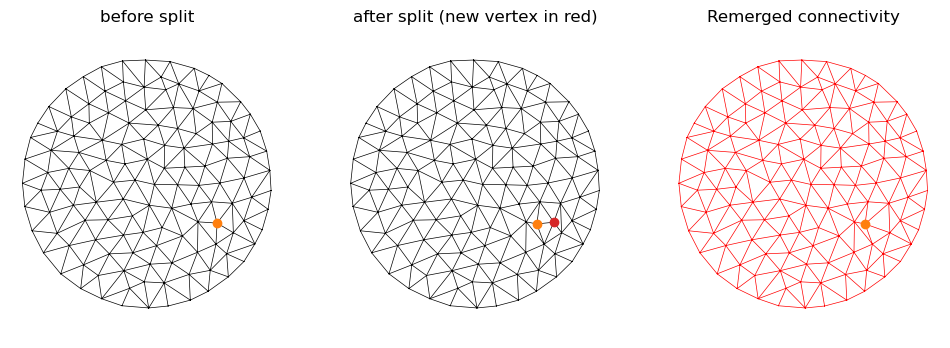

In [46]:
# quick visualization (triangulation plot)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(ax[0])
plt.triplot(*geommesh.vertices.T, hemesh.faces, lw=0.5, color="k")
plt.scatter(*geommesh.vertices[v_split], c="tab:orange")
plt.title("before split")
plt.axis("equal"); plt.axis("off")

plt.sca(ax[1])
plt.triplot(*vertices_split.T, hemesh_split.faces, lw=0.5, color="k")
plt.scatter(*vertices_split[v_split], c="tab:orange")
plt.scatter(*vertices_split[v_new], c="tab:red")
plt.title("after split (new vertex in red)")
plt.axis("equal"); plt.axis("off")

plt.sca(ax[2])
plt.triplot(*vertices_collapsed.T, hemesh_back.faces, lw=0.5, color="r")
plt.scatter(*vertices_split[v_split], c="tab:orange")
plt.title("Remerged connectivity")
plt.axis("equal"); plt.axis("off")

### Next steps

Looks good - the JAX-compatible triangular-mesh data structures seem to work. In particular, the tricky T1/edge-flip function. 
Next steps: linear operators on meshes and geometry processing.

